In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the sunspots data
sunspots_data = pd.read_csv('sunspots_data.csv')#, usecols=['Date', 'Monthly Mean Total Sunspot Number'])

In [3]:
#היכרות ראשונית  עם המידע head/info etc
sunspots_data.info()
sunspots_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7


In [4]:
#לשנות את עמודת התאריך לטיפוס מתאים
sunspots_data['Date'] = pd.to_datetime(sunspots_data['Date'])

In [5]:
sunspots_data.dtypes

,0
Date,datetime64[ns]
Monthly Mean Total Sunspot Number,float64


In [15]:
sunspots_series = np.array(sunspots_data['Monthly Mean Total Sunspot Number'])
time = np.arange(len(sunspots_series))

In [7]:
#sunspots_data.to_csv('sunspots_data.csv', index=False)

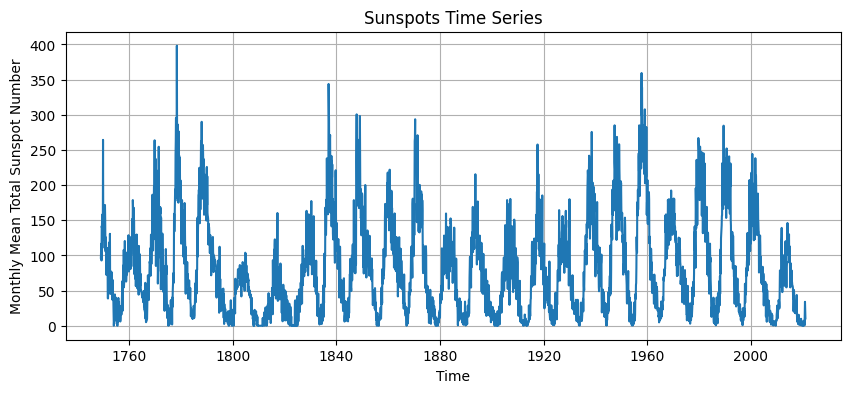

In [8]:
# Plotting the sunspots data
plt.figure(figsize=(10, 4))
#plt.plot(time, sunspots_series)
plt.plot(sunspots_data['Date'], sunspots_data['Monthly Mean Total Sunspot Number'])
plt.title('Sunspots Time Series')
plt.xlabel('Time')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.grid(True)
plt.show()

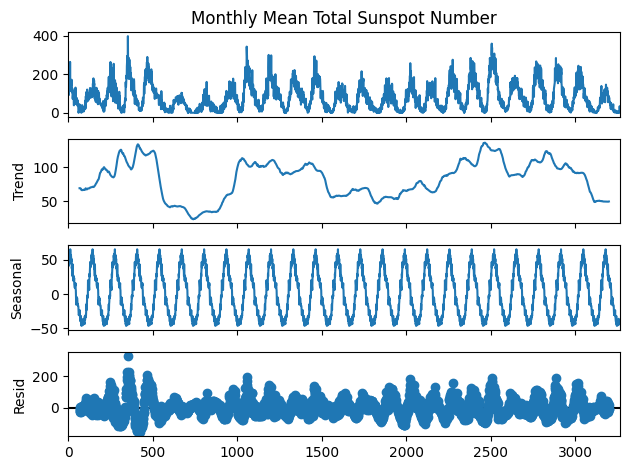

In [9]:
#עונה ומגמה בעזרת seasonal_decompose

result = seasonal_decompose(sunspots_data['Monthly Mean Total Sunspot Number'],
                            model='additive',
                            period=132)#11*12

# הצגת הגרפים
result.plot()
plt.show()


In [10]:
sunspots_series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [14]:
#Scaling
scaler = MinMaxScaler(feature_range=(-1,1))
sunspots_scaled =  scaler.fit_transform(sunspots_data[['Monthly Mean Total Sunspot Number']])
# Split the data into training and validation sets
split_time = int(0.8 * len(sunspots_scaled)) # 80% for training, 20% for validation
x_train = sunspots_scaled[:split_time]
x_valid = sunspots_scaled[split_time:]


In [27]:
# OR - Split the data into training and validation sets
split_time = int(0.8 * len(sunspots_scaled)) # 80% for training, 20% for validation
x_train = sunspots_series[:split_time]
x_valid = sunspots_series[split_time:]


In [28]:
# Helper function to prepare windowed datasets
def windowed_dataset(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map( lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(1)
    return dataset


In [29]:
#אפשר גם ככה
def windowed_dataset_numpy(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])  # חלון של הערכים
        y.append(series[i+window_size])    # הערך הבא אחרי החלון
    return np.array(X), np.array(y)


In [30]:
# Window size and batch size configuration
window_size = 132 #11 years * 12 moths per year
batch_size = 8

# Create windowed datasets for both training and validation
train_dataset = windowed_dataset(x_train, window_size, batch_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size)

In [31]:
for batch in valid_dataset.take(1):  # לוקח באצ' אחד לבדיקה
    X_batch, y_batch = batch
    print(f"Batch shape: {X_batch.shape}, {y_batch.shape}")

Batch shape: (8, 132), (8,)


In [45]:
# Define a simple LSTM/CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(window_size, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                           strides=1,
                           activation='relu',
                           padding='causal',
                          ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x: x * 400)

])

# Compile and train the model
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7,
                                                momentum=0.9),
              metrics=['mae'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset)

Epoch 1/10
    307/Unknown 5s 10ms/step - loss: 11562.0127 - mae: 81.7397

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 11557.9023 - mae: 81.7310 - val_loss: 12746.8223 - val_mae: 86.3160
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 11726.0479 - mae: 82.6567 - val_loss: 12687.5293 - val_mae: 85.9909
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 11327.7090 - mae: 81.9292 - val_loss: 12571.5410 - val_mae: 85.3589
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 11156.7461 - mae: 80.4478 - val_loss: 12377.0215 - val_mae: 84.3325
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 11127.3223 - mae: 79.2295 - val_loss: 12014.3105 - val_mae: 82.4368
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 10399.6104 - mae: 76.8094 - val_loss: 11187.4678 - val_mae: 78.2544
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9513.7607 - mae: 71.2896 - val_loss: 9132.6406 - val_mae: 69.0034
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6921.1733 - mae: 58.7292 - val_loss: 5778.2632 - 

In [46]:
# Function to generate predictions using a trained model
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, #not window_size+1
                             shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)#ירד הshuffle
    forecast = model.predict(dataset)#נוסף
    # # שינוי צורה לפני inverse_transform
    # forecast = forecast.reshape(-1, 1)
    # # החזרת הנתונים לטווח המקורי
    # forecast_original_scale = scaler.inverse_transform(forecast)
    return forecast


# Generate forecasts for the validation set
forecast = model_forecast(model, sunspots_series[split_time - window_size:]
                          #חיזוי החל מחלון אחד לפני הבדיקה
                          , window_size, batch_size)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [34]:
#בדיקה האם מספר החלונות שווה כדי להציג בצורה נוחה על הגרף
print(len(x_valid), len(forecast))

653 654


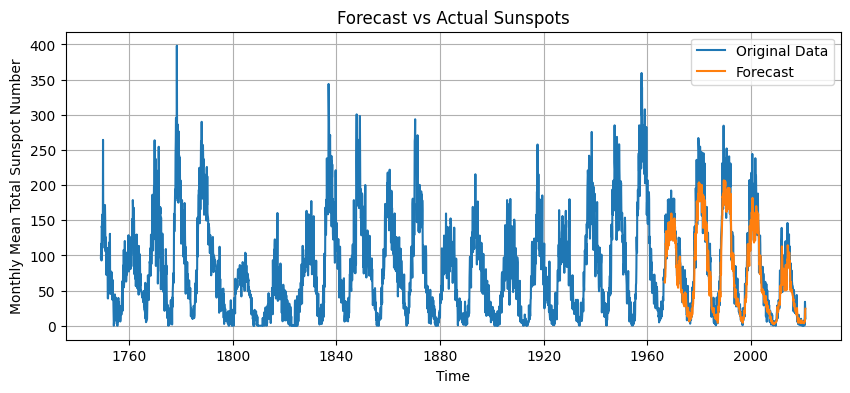

In [43]:
# Plotting the forecasts along with the original data
plt.figure(figsize=(10, 4))
plt.plot(sunspots_data['Date'], sunspots_data['Monthly Mean Total Sunspot Number'], label='Original Data')

plt.plot(sunspots_data['Date'][split_time:], forecast[:-1] #כי יש חלון אחד יותר מידי
         , label='Forecast')
plt.title('Forecast vs Actual Sunspots')
plt.xlabel('Time')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

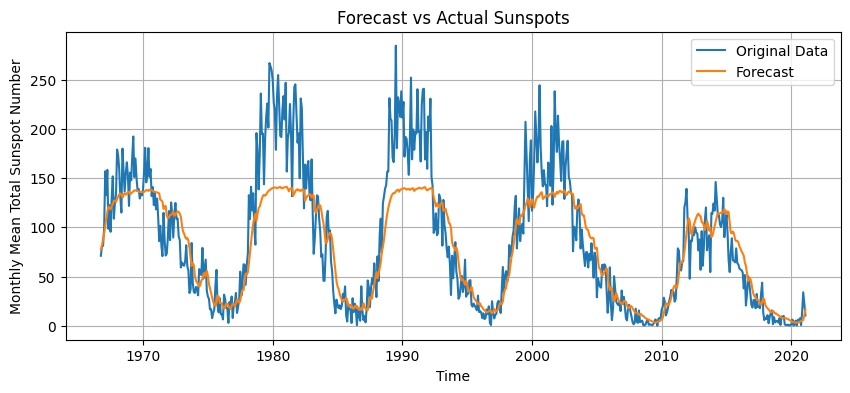

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(sunspots_data['Date'][split_time:], x_valid, label='Original Data')

plt.plot(sunspots_data['Date'][split_time:], forecast[:-1] #כי יש חלון אחד יותר מידי
         , label='Forecast')
plt.title('Forecast vs Actual Sunspots')
plt.xlabel('Time')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
#לגבי הלמדה למה 400 היה נראה כמו רעיון טוב
sunspots_data['Monthly Mean Total Sunspot Number'].max()

398.2

In [29]:
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]
final_train_mae, final_val_mae

(30.526288986206055, 24.753175735473633)

RNN

In [ ]:
# #Scaling
# scaler = MinMaxScaler(feature_range=(-1,1))
# sunspots_scaled =  scaler.fit_transform(sunspots_data[['Monthly Mean Total Sunspot Number']])
# # Split the data into training and validation sets
# split_time = int(0.8 * len(sunspots_scaled)) # 80% for training, 20% for validation
# x_train = sunspots_scaled[:split_time]
# x_valid = sunspots_scaled[split_time:]

# Helper function to prepare windowed datasets
def windowed_dataset(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map( lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    #dataset = dataset.map(lambda window: (tf.expand_dims(window[:-1], axis=-1), window[-1])) #עוד דרך לשנות צורה מראש במקום להוסיף מימד אחר כך
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(1)
    return dataset


#Window size and batch size configuration
window_size = 132 #11 years * 12 moths per year
batch_size = 8

# Create windowed datasets for both training and validation
train_dataset = windowed_dataset(x_train,
                                 window_size, batch_size)#.repeat(count=2)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size)

#RNN
# הוספת מימד
x_train = np.expand_dims(x_train, axis=-1)  # מוסיף ממד אחרון
x_valid = np.expand_dims(x_valid, axis=-1)
#or
# x_train = tf.expand_dims(x_train, axis =-1)
# x_valid = tf.expand_dims(x_valid , axis =-1)


# Define a simple RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),


])

# Compile and train the model
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7,
                                                momentum=0.9),
              metrics=['mae'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset)



# Function to generate predictions using a trained model
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, #not window_size+1
                             shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)#ירד הshuffle
    forecast = model.predict(dataset)#נוסף
    #  # שינוי צורה לפני inverse_transform
    # forecast = forecast.reshape(-1, 1)
    # # # החזרת הנתונים לטווח המקורי
    # forecast_original_scale = scaler.inverse_transform(forecast)
    return forecast


# Generate forecasts for the validation set
forecast = model_forecast(model, sunspots_series[split_time - window_size:]
                          #חיזוי החל מחלון אחד לפני הבדיקה
                          , window_size, batch_size)


# Plotting the forecasts along with the original data
plt.figure(figsize=(10, 4))
plt.plot(sunspots_data['Date'], sunspots_data['Monthly Mean Total Sunspot Number'], label='Original Data')

plt.plot(sunspots_data['Date'][split_time:], forecast[:-1] #כי יש חלון אחד יותר מידי
         , label='Forecast')
plt.title('Forecast vs Actual Sunspots')
plt.xlabel('Time')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(sunspots_data['Date'][split_time:],  sunspots_data['Monthly Mean Total Sunspot Number'][split_time:], label='Original Data')

plt.plot(sunspots_data['Date'][split_time:], forecast[:-1] #כי יש חלון אחד יותר מידי
         , label='Forecast')
plt.title('Forecast vs Actual Sunspots')
plt.xlabel('Time')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()